<h1 align = center> Limpieza de la Base de Datos </h1>

Usualmente las bases de datos presentan muchos posibles problemas, como datos faltantes y datos atipicos que se deben tratar para poder utilizar la base de datos.

## Tratamiento de Na's

Lo primero que se hace es realizar la lectura de la base de datos

In [ ]:
url1   <- "https://raw.githubusercontent.com/joanby/r-course/master/data/tema1/missing-data.csv"
data1R <- read.csv(url1, row.names=NULL)
head(data1R, 5)

### Estandarizar los NAN

In [3]:
data1R$Income[data1R$Income == 0]          <- NA
data1R$Phone_type[data1R$Phone_type == ""] <- NA
data1R$Car_type[data1R$Car_type == ""]     <- NA

head(data1R, 5)

Income,Phone_type,Car_type
89800,Android,Luxury
47500,Android,Non-Luxury
45000,iPhone,Luxury
44700,NA,Luxury
59500,iPhone,Luxury


### Observación de NA's e Identificación de Patrones
Contar el número de NAN por variable (columna).

In [5]:
colSums(is.na(data1R))

library(dplyr)
summarise_all(data1R, funs(sum(is.na(.))))

Income Phone_type   Car_type 
         5          2          0

Income,Phone_type,Car_type
5,2,0


Dependiendo del contexto en ocasiones el ruido que introduce una variable cuando contiene muchos valores nulos es demasiado, por lo tanto es una buena tecnica observar el patron que siguen lis NA's.

In [2]:
url3         <- "https://raw.githubusercontent.com/joanby/r-course/master/data/tema1/housing-with-missing-value.csv"
data3R       <- read.csv(url3)
housing.data <- data3R

,X,crim,zn,indus,chas,nox,rm,age,dis,tax,b,lstat,medv,rad,ptratio,
431,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
35,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1
35,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1
5,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,2
,0,0,0,0,0,0,0,0,0,0,0,0,0,40,40,80


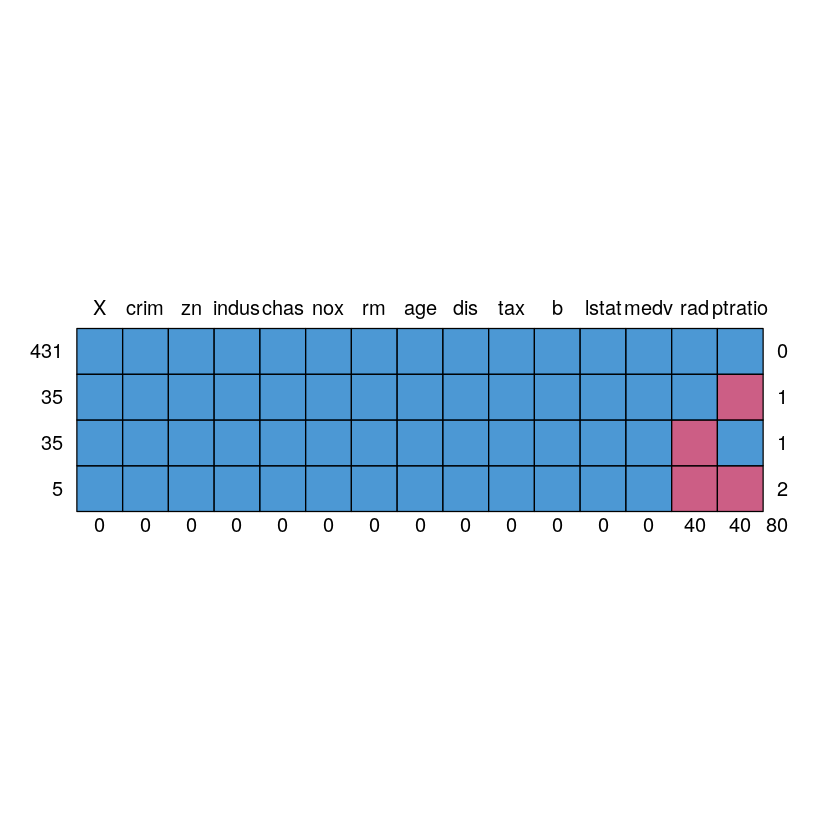

In [3]:
library(mice)
md.pattern(housing.data)

In [8]:
library(VIM)

aggr(housing.data,
     col= c('blue
', 'red'),
     numbers = TRUE, 
     sortVars = TRUE,
     labels = names(housing.data),
     cex.axis = 0.75,
     gap = 1,
     ylab = c("Histograma de NAs", "Patrón")
)     

ERROR: Error in library(VIM): there is no package called ‘VIM’


### Eliminar los NA

Es posible que eliminar los Na, la forma más simple de hacerlo es eliminar todas las filas que contengan algún valor nulo.

In [9]:
ingresos <- na.omit(data1R)
head(ingresos, 5)

,Income,Phone_type,Car_type
1,89800,Android,Luxury
2,47500,Android,Non-Luxury
3,45000,iPhone,Luxury
5,59500,iPhone,Luxury
7,63300,iPhone,Non-Luxury


In [10]:
ingresos <- data1R[complete.cases(data1R),]
head(ingresos, 5)

,Income,Phone_type,Car_type
1,89800,Android,Luxury
2,47500,Android,Non-Luxury
3,45000,iPhone,Luxury
5,59500,iPhone,Luxury
7,63300,iPhone,Non-Luxury


Aunque tambien esta la opción de eliminar las filas que tengan un valor nulo en una variable concreta.

In [11]:
ingresos <- data1R[!is.na(data1R$Income),]
colSums(is.na(ingresos))
head(ingresos, 5)

Income Phone_type   Car_type 
         0          2          0

Income,Phone_type,Car_type
89800,Android,Luxury
47500,Android,Non-Luxury
45000,iPhone,Luxury
44700,NA,Luxury
59500,iPhone,Luxury


Támbien existe la posibilidad de que alguna variable tenga tantos NA's que sea más conveniente eliminarla.

In [12]:
ingresos$Phone_type <- NULL
head(ingresos, 5)

Income,Car_type
89800,Luxury
47500,Non-Luxury
45000,Luxury
44700,Luxury
59500,Luxury


### Imputación de NA's

#### Imputación por media

In [13]:
mean(data1R$Income)
mean(data1R$Income, na.rm=T)

sd(data1R$Income)
sd(data1R$Income, na.rm=T)

[1] NA

[1] 65763.64

[1] NA

[1] 26715.87

In [14]:
ingresos             <- data1R
ingresos$Income.mean <- ifelse(is.na(ingresos$Income), 
                           mean(ingresos$Income, na.rm=TRUE),
                           ingresos$Income
                           )
head(ingresos,5)

Income,Phone_type,Car_type,Income.mean
89800,Android,Luxury,89800
47500,Android,Non-Luxury,47500
45000,iPhone,Luxury,45000
44700,NA,Luxury,44700
59500,iPhone,Luxury,59500


In [15]:
mean(ingresos$Income.mean)
sd(ingresos$Income.mean)

[1] 65763.64

[1] 24010.01

Tambien existe un paquete llamado *Hmisc* que permite relizar esto sin necesidad e crear una función, además permite realizar un cambio en el criterio de imputación

In [16]:
housing.data <- data3R
summary(housing.data$ptratio)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  12.60   17.40   19.10   18.47   20.20   22.00      40 

In [17]:
library(Hmisc)
housing.data$ptratio <- impute(housing.data$ptratio, mean)
summary(housing.data$ptratio)

Loading required package: survival
Loading required package: Formula
Loading required package: ggplot2

Attaching package: ‘Hmisc’

The following objects are masked from ‘package:dplyr’:

    src, summarize

The following objects are masked from ‘package:base’:

    format.pval, units




 40 values imputed to 18.4676 



   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  12.60   17.40   18.60   18.47   20.20   22.00 

Además tambien es posible realizar la imputación 

In [18]:
housing.data <- data3R
housing.data$ptratio <- impute(housing.data$ptratio, median)
summary(housing.data$ptratio)


 40 values imputed to 19.1 



   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  12.60   17.40   19.10   18.52   20.20   22.00 

In [19]:
housing.data <- data3R
housing.data$ptratio <- impute(housing.data$ptratio, 18)
summary(housing.data$ptratio)


 40 values imputed to 18 



   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  12.60   17.40   18.60   18.43   20.20   22.00 

#### Computar Valores aleatorios

Cuanto tengo valores faltantes, tanto en variables númericas como categoricas de forma que por medio de un muestreo aleatorio se reeemplazan los valores faltantes. Para esto es conveniente construir una función

In [20]:
random.impute        <- function(x) {
    missing          <- is.na(x)
    n.missing        <- sum(missing)
    x.obs            <- x[!missing]
    imputed          <- x
    imputed[missing] <- sample(x.obs, n.missing, replace=TRUE)
    return(imputed)
}

Primero uye se construye un vector con los valores nulos **missing**, y los sumamos para saber cuales valores hay que reemplazar **n.missing**, luego  se saca un vector de los valores no nulos **x.obs**, **imputed** devuelve por defecto los valores que habian en los valores no nulos y finalmente **imputed[missing]** Permite reemplazar aletoriamente los valores nulos con valores observados.

In [21]:
ingresos                    <- data1R
ingresos$Phone_type.imputed <- random.impute(ingresos$Phone_type)
colSums(is.na(ingresos))

Income         Phone_type           Car_type Phone_type.imputed 
                 5                  2                  0                  0

Cuando los datos que se tienen en la base de datos fueron tomados de forma totalmente aleatoria, es posible optar por realizar una imputación aleatoria de todos los datos de la variable

In [22]:
random.impute.data.frame <- function(dataframe, cols){
  names                  <- names(dataframe)
  for(col in cols){
    name                 <- paste(names[col], "imputed", sep = ".")
    dataframe[name]      = random.impute(dataframe[,col])
  }
  dataframe
}

In [23]:
ingresos <- data1R
ingresos <- random.impute.data.frame(ingresos, c(1,2))
colSums(is.na(ingresos))

Income         Phone_type           Car_type     Income.imputed 
                 5                  2                  0                  0 
Phone_type.imputed 
                 0

In [24]:
drop_na        <- c("rad")
housing.data.2 <- housing.data[ 
  complete.cases(housing.data[,!(names(housing.data))%in% drop_na]),]
head(housing.data.2, 5)
dim(housing.data.2)

X,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
1,0.00632,18,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
2,0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
3,0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
4,0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
5,0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


[1] 506  15

#### Imputación con Modelos Predictivos

En ocasiones cuando un reemplazo de valores aleatorios no es el adecuado, y el uso de la media y mediana genera mucho ruido es usual utilizar modelos predictivos para generar los valores.

In [25]:
library(mice)
housing.data <- data3R
head(housing.data, 5)
dim(housing.data)

X,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
1,0.00632,18,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
2,0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
3,0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
4,0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
5,0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


[1] 506  15

In [26]:
colSums(is.na(housing.data))

X    crim      zn   indus    chas     nox      rm     age     dis     rad 
      0       0       0       0       0       0       0       0       0      40 
    tax ptratio       b   lstat    medv 
      0      40       0       0       0

Para hacer esto se hace uso del paquete **mice**

* m: Es el número de imputaciones que quiero hacer
* maxit: Es el número maximo de iteraciones
* seed: Es la semilla; todos los métodos de reemplazo del paquete son aleatorios, y la semilla va cambiando si esta no se fija cambiando los valores con los que se imputo.
* method: Metodo de reemplazo
    + pmm - comparación predictiva de medias
    + logreg - regresión logistica
    + polyreg - regresión logística politómica
    + polr - modelo de probabilidades proporcionales
    
**nota:** Para generar números pseudo aleatorios se utiliza un generador lineal congruencial

In [27]:
columns <- c("ptratio", "rad")

##### Imputación por Comparación Predictiva de medias

In [28]:
imputed_data <- mice(housing.data[,names(housing.data) %in% columns],
                     m = 5, 
                     maxit = 50, 
                     method = "pmm",
                     seed = 2018)


 iter imp variable
  1   1  rad  ptratio
  1   2  rad  ptratio
  1   3  rad  ptratio
  1   4  rad  ptratio
  1   5  rad  ptratio
  2   1  rad  ptratio
  2   2  rad  ptratio
  2   3  rad  ptratio
  2   4  rad  ptratio
  2   5  rad  ptratio
  3   1  rad  ptratio
  3   2  rad  ptratio
  3   3  rad  ptratio
  3   4  rad  ptratio
  3   5  rad  ptratio
  4   1  rad  ptratio
  4   2  rad  ptratio
  4   3  rad  ptratio
  4   4  rad  ptratio
  4   5  rad  ptratio
  5   1  rad  ptratio
  5   2  rad  ptratio
  5   3  rad  ptratio
  5   4  rad  ptratio
  5   5  rad  ptratio
  6   1  rad  ptratio
  6   2  rad  ptratio
  6   3  rad  ptratio
  6   4  rad  ptratio
  6   5  rad  ptratio
  7   1  rad  ptratio
  7   2  rad  ptratio
  7   3  rad  ptratio
  7   4  rad  ptratio
  7   5  rad  ptratio
  8   1  rad  ptratio
  8   2  rad  ptratio
  8   3  rad  ptratio
  8   4  rad  ptratio
  8   5  rad  ptratio
  9   1  rad  ptratio
  9   2  rad  ptratio
  9   3  rad  ptratio
  9   4  rad  ptratio
  9   5  rad

In [29]:
summary(imputed_data)

Class: mids
Number of multiple imputations:  5 
Imputation methods:
    rad ptratio 
  "pmm"   "pmm" 
PredictorMatrix:
        rad ptratio
rad       0       1
ptratio   1       0


Despues de generar los valores de forma aleatoria se reemplazan los NA's por los valores generados

In [30]:
housing.data$ptratio <- mice::complete(imputed_data)$ptratio
housing.data$rad <- mice::complete(imputed_data)$rad
colSums(is.na(housing.data))
anyNA(housing.data)

X    crim      zn   indus    chas     nox      rm     age     dis     rad 
      0       0       0       0       0       0       0       0       0       0 
    tax ptratio       b   lstat    medv 
      0       0       0       0       0

[1] FALSE

#### Imputación automatica

Es posible utilizar el paquete **hmisc** para que este elija de forma automatica elmétodo e impute los NA's.

In [31]:
impute_arg <- aregImpute(~ptratio + rad, data = housing.data, n.impute = 5)

impute_arg

impute_arg$imputed$rad

Iteration 5 



Multiple Imputation using Bootstrap and PMM

aregImpute(formula = ~ptratio + rad, data = housing.data, n.impute = 5)

n: 506 	p: 2 	Imputations: 5  	nk: 3 

Number of NAs:
ptratio     rad 
      0       0 

        type d.f.
ptratio    s   NA
rad        s   NA

Transformation of Target Variables Forced to be Linear

R-squares for Predicting Non-Missing Values for Each Variable
Using Last Imputations of Predictors
named numeric(0)

NULL

## Valores Duplicados

En ocasiones encontramos valores duplicados, o registros duplicados en una valiable, lo primero es verificar si hay registros duplicados en el data frame.

In [32]:
family.salary <- c(40000, 60000, 50000, 80000, 60000, 70000, 60000)
family.size   <- c(4, 3, 2, 2, 3, 4, 3)
family.car    <- c("Lujo", "Compacto", "Utilitario", "Lujo", 
               "Compacto", "Compacto", "Compacto")
family        <- data.frame(family.salary, family.size, family.car)
family

family.salary,family.size,family.car
40000,4,Lujo
60000,3,Compacto
50000,2,Utilitario
80000,2,Lujo
60000,3,Compacto
70000,4,Compacto
60000,3,Compacto


In [33]:
duplicated(family)
family[duplicated(family),]

[1] FALSE FALSE FALSE FALSE  TRUE FALSE  TRUE

,family.salary,family.size,family.car
5,60000,3,Compacto
7,60000,3,Compacto


Ahora cuando se encuentran valores duplicados en un data frame, estos se pueden eliminar utilizando la función unique.

In [34]:
family.unique <- unique(family)
family.unique

,family.salary,family.size,family.car
1,40000,4,Lujo
2,60000,3,Compacto
3,50000,2,Utilitario
4,80000,2,Lujo
6,70000,4,Compacto


## Tratamiento de Outliers

En estadistica se conoce como *rango intercuartilico* $RI$ a la distancia que hay entre el cuartil uno $Q_1$ y el cuartil tres $Q_3$, y se considera un outlier un dato que este por fuera de $[Q_1-1.5RI, Q_3+1.5RI]$.

### Identificación de Outliers

Para identificar si hay valores atipicos en un grupo de datos una de las herramientas más utilies es el uso de boxplots.

In [35]:
url5       <- "https://raw.githubusercontent.com/joanby/r-course/master/data/tema1/ozone.csv"
data5R     <- read.csv(url5, stringsAsFactors=F)
ozone.data <- data5R
head(ozone.data, 5)

Month,Day_of_month,Day_of_week,ozone_reading,pressure_height,Wind_speed,Humidity,Temperature_Sandburg,Temperature_ElMonte,Inversion_base_height,Pressure_gradient,Inversion_temperature,Visibility
1,1,4,3.01,5480,8,20,NA,NA,5000,-15,30.56,200
1,2,5,3.20,5660,6,NA,38,NA,NA,-14,NA,300
1,3,6,2.70,5710,4,28,40,NA,2693,-25,47.66,250
1,4,7,5.18,5700,3,37,45,NA,590,-24,55.04,100
1,5,1,5.34,5760,3,51,54,45.32,1450,25,57.02,60


[1] 5480 5410 5350 5480 5490 5470 5320 5420 5440 5480 5450 5500

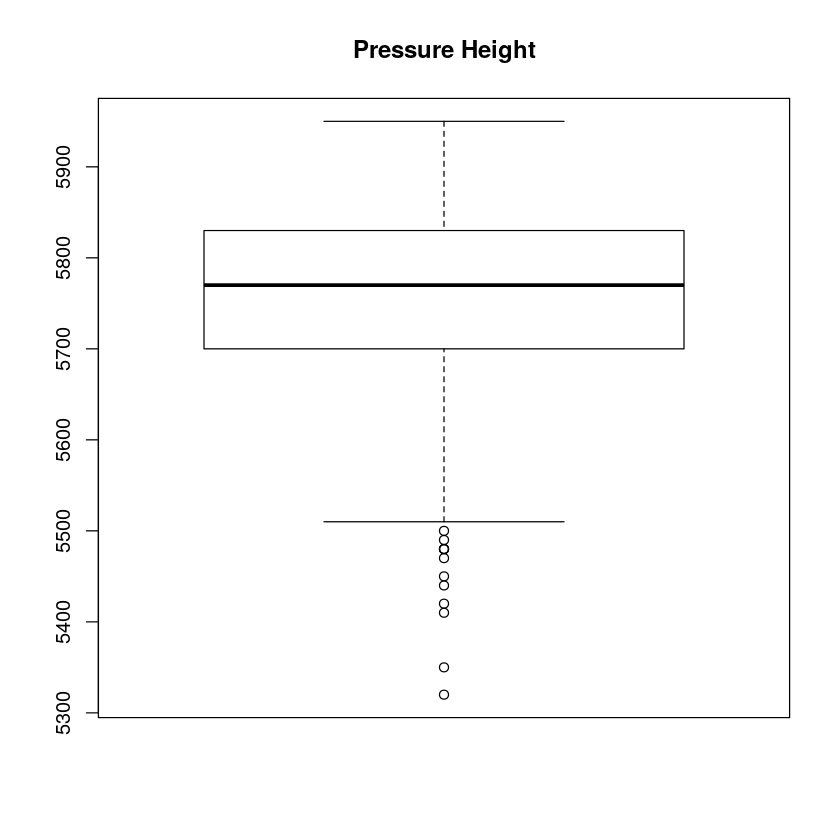

In [36]:
boxplot(ozone.data$pressure_height, 
        main = "Pressure Height",
        boxwex = 1.5)$out

El parametro out se utiliza para que aparezca cuales son las observaciones que son outliers en la variable analizada.

En ocasiones es importante observar si los outlaiers tienen realción con otra variable.

[1] 11.06  9.93 22.89 24.29 29.79

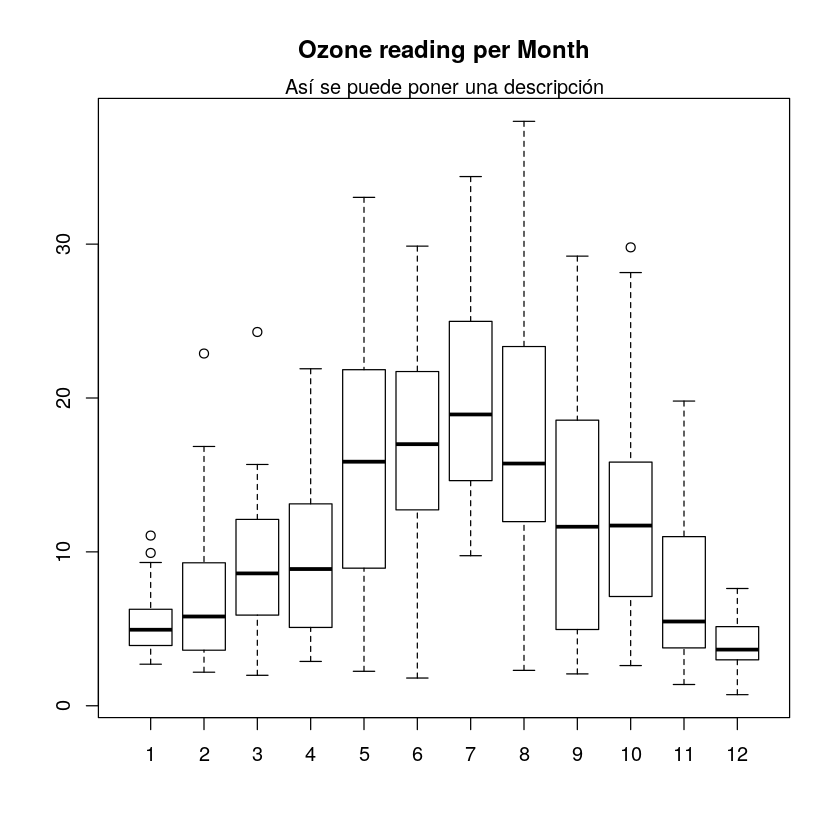

In [38]:
boxplot(ozone_reading ~Month,
        data = ozone.data,
        main = "Ozone reading per Month")$out

mtext("Así se puede poner una descripción")

Exiten tambien otros métodos, para identicar los outlaiers

### Imputación de Atípicos

In [40]:
replace_outliers <- function(x, removeNA=TRUE){
    q1   <- quantile(x,probs=0.25, na.rm=removeNA)
    q3   <- quantile(x,probs=0.75, na.rm=removeNA)
    ri   <- q3 - q1   
    caps <- quantile(x, probs = c(.05, .95), na.rm = removeNA)  
    x[x<q1-1.5 * ri] <- caps[1]
    x[x>q3+1.5 * ri] <- caps[2]
    x
    }

In [41]:
capped_pressure_height <- replace_outliers(ozone.data$pressure_height)
head(capped_pressure_height,5)

[1] 5550 5660 5710 5700 5760

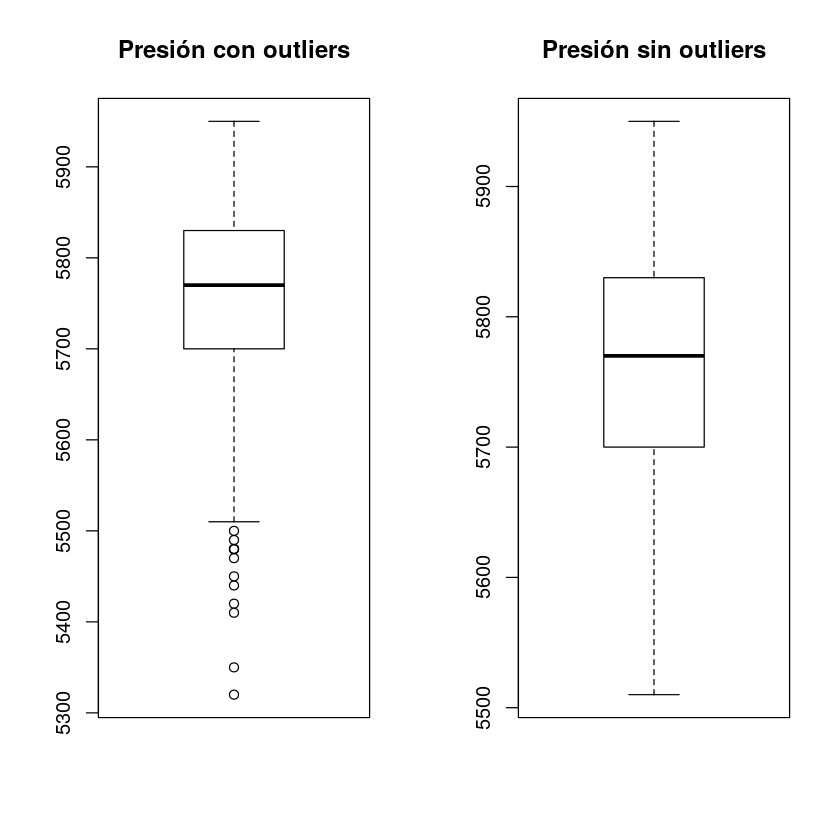

In [42]:
par(mfrow = c(1,2))
boxplot(ozone.data$pressure_height, main = "Presión con outliers")
boxplot(capped_pressure_height, main = "Presión sin outliers")

### Guardar la nueva base de datos

Por motivos de replicabilidad es adecuado generar una nueva base de datos en lugar de modificar la original, aal momento de continuar con el analisis.

In [ ]:
write.csv(MyData, file = "MyData.csv")